# Setup the environemnt and install all packages 

________________
## Setup 🔧

**1. Clone the repository**

```bash
git clone https://github.com/Cerlog/02807-project
```

**2. Create conda environment** 
```bash
conda create -n 02807-project python=3.11.14 -y
```

**3. Activate the environment**
```bash 
conda activate 02807-project
```

**4. Change the directories** 
```bash
cd 02807-project
```
**5. Install the requirements**

```bash
pip install -r requirements.txt
```
_______________

# Integrating Graph Clustering and Association Rule Mining on the Yelp Dataset for Detection of Global and Local Patterns

In [1]:
# imports 
import os
import json
import nltk
import random
import community.community_louvain as community_louvain  
from networkx.algorithms.community import modularity
import sys
import importlib
import pickle
import torch
import tqdm as notebook_tqdm
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt


from pathlib import Path
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from collections import defaultdict
from src.functions import *
from transformers import AutoTokenizer
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import matplotlib.cm as cm
#
## set paths
PROJECT_ROOT = Path().resolve()
SRC_DIR = PROJECT_ROOT / "src"
sys.path.append(str(SRC_DIR))
sys.path.insert(0, str(SRC_DIR))

# functions
import data as d
import apriori as ap
import preprocessing as pr

# set random seed for reproducibility
SEED = 1337
os.environ["PYTHONHASHSEED"] = str(SEED)  
random.seed(SEED)
np.random.seed(SEED)
rng = np.random.default_rng(SEED)  


# Define base directory
DATA_DIR_RAW = Path("data/raw")
DATA_DIR_PROC = Path("data/processed")

# Define file paths
USERS   = DATA_DIR_RAW / "yelp_academic_dataset_user.json"
REVIEWS = DATA_DIR_RAW / "yelp_academic_dataset_review.json"
REVIEWS_CLEAN = DATA_DIR_RAW / "review_clean.ndjson"
BIZ     = DATA_DIR_RAW / "yelp_academic_dataset_business.json"

# categories of restaurants
FOOD = DATA_DIR_RAW / "Food.txt"
RESTAURANTS = DATA_DIR_RAW / "restaurants.txt"


# pull the datasets from google drive
DATASET_URLS = [
    "https://drive.google.com/file/d/163KgvKNYPTV5_fArvlBiNkqb6rCDkk-Z/view?usp=drive_link",
    "https://drive.google.com/file/d/1O5kEcRxvnO1da74y9y5AE92h_QlOfjmL/view?usp=drive_link",
    "https://drive.google.com/file/d/1ox-qrD1sSKalbu25FIbu-kYGMvkn3Y3k/view?usp=drive_link", 
    "https://drive.google.com/file/d/1cJx0UUVxwsKL8DHpwrGoqBSlRA2v4I2f/view?usp=drive_link",
    "https://drive.google.com/file/d/10wpi7RzZTpt93_7uRZcshvA5X3ek3_Kc/view?usp=drive_link"
]

# https://www.kaggle.com/datasets/yaldayazdanpanah/yelpcategorytitles/data
#https://business.yelp.com/data/resources/open-dataset/

/home/pnylander/miniconda3/envs/final/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Get the dataset 

In [2]:
d.download_dataset(DATASET_URLS, DATA_DIR_RAW)

2025-12-05 09:57:33.759 | INFO     | data:download_dataset:35 - Downloading from https://drive.google.com/file/d/163KgvKNYPTV5_fArvlBiNkqb6rCDkk-Z/view?usp=drive_link...
Downloading...
From (original): https://drive.google.com/uc?id=163KgvKNYPTV5_fArvlBiNkqb6rCDkk-Z
From (redirected): https://drive.google.com/uc?id=163KgvKNYPTV5_fArvlBiNkqb6rCDkk-Z&confirm=t&uuid=6274ec39-55cd-4509-bb16-83ce02c3921e
To: /home/pnylander/DTU/4thSemester/02807/02807-project/yelp_academic_dataset_user.json
100%|██████████| 3.36G/3.36G [01:55<00:00, 29.2MB/s]
2025-12-05 09:59:32.870 | SUCCESS  | data:download_dataset:42 - ✅ Downloaded to 'data/raw/yelp_academic_dataset_user.json'
2025-12-05 09:59:32.871 | WARNING  | data:clean_review_json:10 - Can't find 'review.json' to clean.
2025-12-05 09:59:32.872 | INFO     | data:download_dataset:35 - Downloading from https://drive.google.com/file/d/1O5kEcRxvnO1da74y9y5AE92h_QlOfjmL/view?usp=drive_link...
Downloading...
From (original): https://drive.google.com/uc?id=

# Processing the dataset 

Importing of the needed parts of the Yelp dataset.

In [4]:
# import the data
user = pd.read_json(USERS, lines=True, dtype={"user_id": str}, engine="pyarrow")
review = pd.read_json(REVIEWS_CLEAN, lines=True, engine="pyarrow")
business = pd.read_json(BIZ, lines=True, engine="pyarrow")

# drop all the nans within categories
business = business.dropna(subset=["categories"])
business = business.reset_index(drop=True) # reset the index after dropping nans 

We are intersted only in the reviews of businesses which are food and restaurants related, so therefore we filter the business dataset to only contain those entries.

In [5]:
is_food_rest = business["categories"].str.contains(r"\b(?:Restaurants|Food)\b", case=False, na=False)
business = business.loc[is_food_rest].copy().reset_index(drop=True)

In [5]:
# save the business for later use 
#business.to_json(DATA_DIR_PROC / "business_food_restaurants.json", orient="records", lines=True)

Now we have only the food and restaurant related businesses in the business dataframe. The problem is however, that many of the reviews are for businesses contain multiple categories, see the examples bellow. Therefore we need to reduce the categories to only one per business. From the the kaggle dataset, we have all the categories within **Restaurants** and **Foods** that are included in the yelp dataset, from which we will build a dictionary of the categories in the entire dataset in order to reduce the multiple categories into only one overall category per business. 


In [6]:
# creating the categories in order list
pr.CATEGORIES_IN_ORDER = pr.get_categories(RESTAURANTS, FOOD)

Creating new column based on the reduced categories.

In [7]:
random.seed(SEED)
np.random.seed(SEED)
business["simple_category"] = business["categories"].apply(pr.simplify_random)

In [ ]:
# save the dataframe for later use
#business.to_json(DATA_DIR_PROC / "business_food_restaurants_simple_categories.json", orient="records", lines=True)

In order to see how this affects the distribution of the dataset, i.e. of choosing Bubble Tea instead of Coffee & Tea, we run a simple experiment to see see if the categories are affected by this simplification. 

In [8]:
pr.test_distribution(business, n_runs=100, run_index=SEED)

mean:
  Mean: 4.98e-03
  Std Dev: 1.03e-02
  Range: [1.55e-05, 5.87e-02]

std:
  Mean: 8.62e-19
  Std Dev: 2.41e-18
  Range: [0.00e+00, 2.09e-17]



From the 100 trials (plan was to do more, but it took much longer time than expected), we can see that when choosen at random, the distribution odes not change significantly, therefore we can justify the simplification of the categories. 

In [9]:
print(f"Number of unique simplified categories: {len(business['simple_category'].unique())}")

Number of unique simplified categories: 200


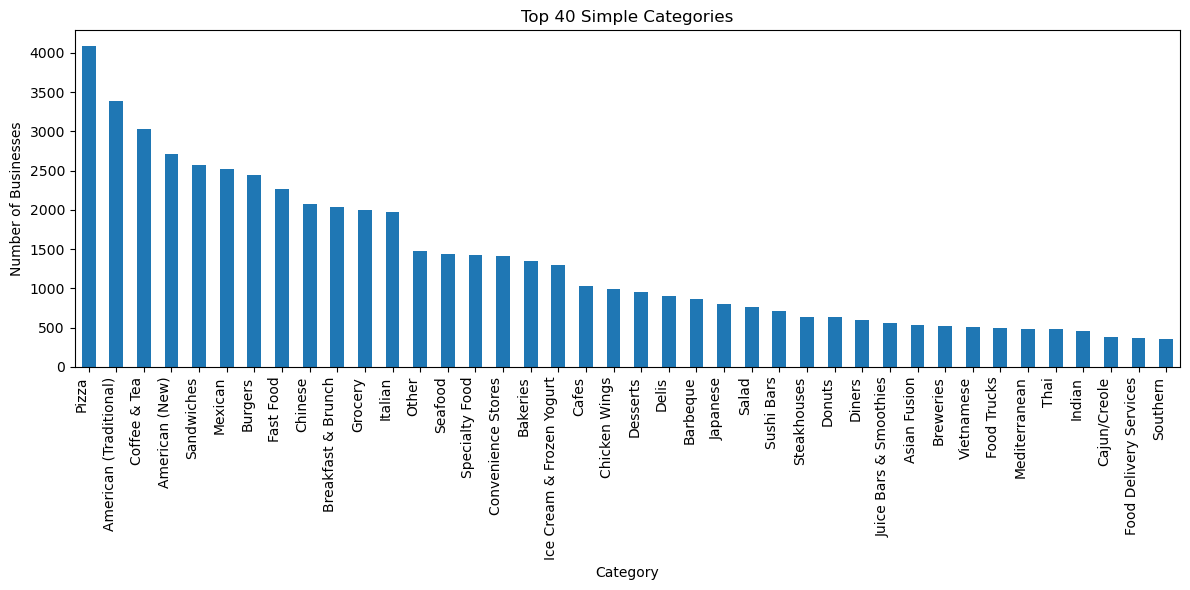

In [10]:
top_k_simple_categories = 40
category_counts = business["simple_category"].value_counts().sort_values(ascending=False)
plt.figure(figsize=(12,6))
category_counts.head(top_k_simple_categories).plot(kind='bar')
plt.title(f"Top {top_k_simple_categories} Simple Categories")
plt.xlabel("Category")
plt.ylabel("Number of Businesses")
plt.xticks(rotation=90, ha="right")  
plt.tight_layout()                  
plt.savefig("figures/simple_categories_distribution.svg",dpi=300)
plt.show()


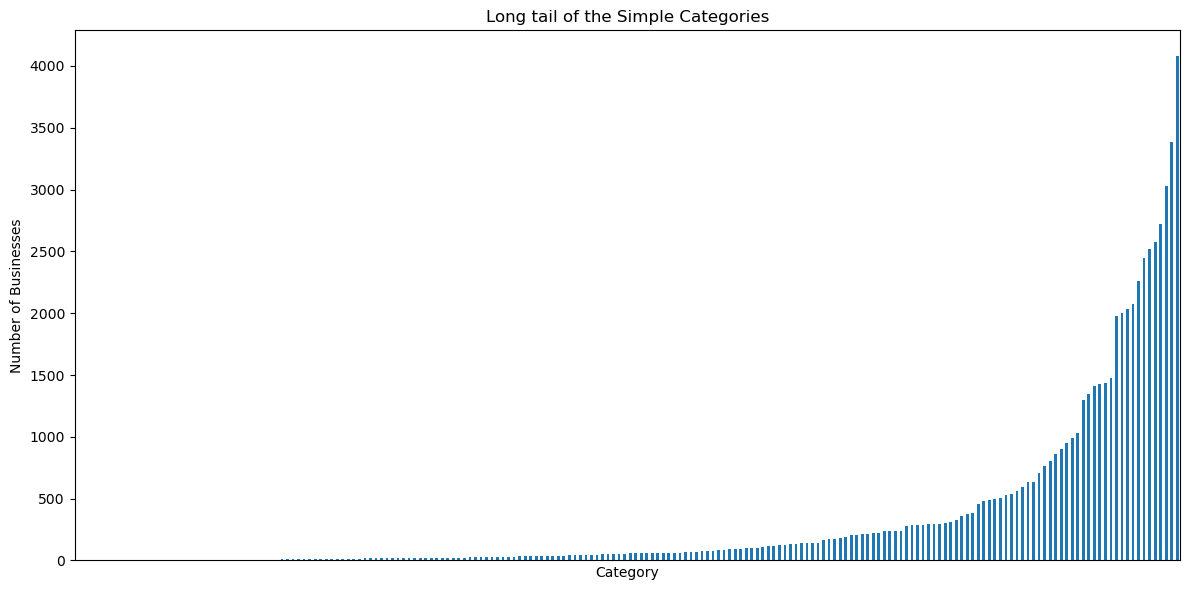

In [11]:
bottom_k_simple_categories = None
category_counts = business["simple_category"].value_counts().sort_values(ascending=True)
plt.figure(figsize=(12,6))
ax = category_counts.head(bottom_k_simple_categories).plot(kind='bar')
ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
plt.title(f"Long tail of the Simple Categories")
plt.xlabel("Category")
plt.ylabel("Number of Businesses")
plt.tight_layout()
plt.savefig("figures/simple_categories_least_common.svg", dpi=300)
plt.show()


Now, that we have the reduced categories, we need to process the data into a form, that can be used by the apriori algorithm.

In [12]:
# Load and prepare business mapping
#business.to_parquet(DATA_DIR_PROC / "business_processed.parquet", index=False)

In [13]:
biz_proc = pd.read_parquet(DATA_DIR_PROC / "business_processed.parquet")[["business_id", "simple_category"]]

The Apriori algorithm is most efficient, if we assign every category an unique integer ID and threffore we need to create a mapping from category to ID and vice versa.

In [14]:
# create a list of alphabetically sorted unique categories
cats = sorted(biz_proc["simple_category"].drop_duplicates().to_list())
#print(f"Unique simplified categories: {cats}")
# create dictionary mapping from category to ID
cat_to_id = {cat: idx for idx, cat in enumerate(cats)}
#print(f"Category to ID mapping: {cat_to_id}")
# create reverse mapping from ID to category
id2cat_map = {idx: cat for cat, idx in cat_to_id.items()}
#print(f"ID to Category mapping: {id2cat_map}")

# Save category vocabulary
pd.DataFrame({"cat_id": range(len(cats)), "simple_category": cats}).to_parquet(
    DATA_DIR_PROC / "cat_vocab.parquet", index=False
)

Now, we create a lookup table for the businesses to their assigned category IDs.

In [15]:
# Create business mapping
biz_map = (biz_proc.assign(cat_id=lambda d: d["simple_category"].map(cat_to_id))[["business_id", "cat_id"]].drop_duplicates("business_id").set_index("business_id"))
biz_map.head()
print(f"Created mappings for {len(cats)} categories")
biz_map

Created mappings for 201 categories


,cat_id
business_id,
MTSW4McQd7CbVtyjqoe9mw,43
mWMc6_wTdE0EUBKIGXDVfA,21
CF33F8-E6oudUQ46HnavjQ,67
k0hlBqXX-Bt0vf1op7Jr1w,82
bBDDEgkFA1Otx9Lfe7BZUQ,67
...,...
cM6V90ExQD6KMSU3rRB5ZA,29
1jx1sfgjgVg0nM6n3p0xWA,44
WnT9NIzQgLlILjPT0kEcsQ,121


Now we create a sets of liked and hated category IDs per user. Where we for each user build a set of categories they liked and disliked based on the star ratings in their reviews.

In [ ]:
liked_ids = defaultdict(set)
hated_ids = defaultdict(set)

usecols = ["user_id", "business_id", "stars"]

Because of the size of the review dataset, we process the reviews in chunks of 500.000 entries at a time to avoid memory issues. 

In this code, we crate two baskets for each user, one with the categories they liked (gave review stars >= 4) and one with the categories they hated (gave review stars < 3). 

In [ ]:
for chunk in pd.read_json(REVIEWS_CLEAN, lines=True, dtype_backend="pyarrow", chunksize=500_000):
    r = (chunk[usecols]
         .dropna(subset=["user_id", "business_id", "stars"])
         .copy())
    
    # Convert to string
    r["user_id"] = r["user_id"].astype("string[pyarrow]")
    r["business_id"] = r["business_id"].astype("string[pyarrow]")
    
    
    # Split by stars
    high = r[r["stars"] >= 4.0]
    low = r[r["stars"] < 3.0]  # 
    
    # Join with business mapping and accumulate
    if len(high):
        high = high.join(biz_map, on="business_id", how="inner")
        for uid, cats in high.groupby("user_id")["cat_id"]:
            liked_ids[str(uid)].update(cats.unique())
    
    if len(low):
        low = low.join(biz_map, on="business_id", how="inner")
        for uid, cats in low.groupby("user_id")["cat_id"]:
            hated_ids[str(uid)].update(cats.unique())

Now, we created the dataframes and keep the baskets that have at least 2 items. 

In [ ]:
# Create basket dataframes
liked_baskets_ids = pd.DataFrame({
    "user_id": list(liked_ids.keys()),
    "items": [sorted(list(s)) for s in liked_ids.values()]
})

hated_baskets_ids = pd.DataFrame({
    "user_id": list(hated_ids.keys()),
    "items": [sorted(list(s)) for s in hated_ids.values()]
})

# 
liked_baskets_ids = liked_baskets_ids[liked_baskets_ids["items"].map(len) >= 2]
hated_baskets_ids = hated_baskets_ids[hated_baskets_ids["items"].map(len) >= 2]

# Save all basket variants
liked_baskets_ids.to_parquet(DATA_DIR_PROC / "baskets_liked_ids.parquet", index=False)
hated_baskets_ids.to_parquet(DATA_DIR_PROC / "baskets_hated_ids.parquet", index=False)

print(f"Liked baskets: {len(liked_baskets_ids)} users (with 2+ items)")
print(f"Hated baskets: {len(hated_baskets_ids)} users (with 2+ items)")

Liked baskets: 326145 users (with 2+ items)
Hated baskets: 101028 users (with 2+ items)


In [ ]:
liked_baskets_ids.head()

,user_id,items
0,---2PmXbF47D870stH1jqA,"[3, 4, 46, 74, 121, 151, 155, 168]"
1,---UgP94gokyCDuB5zUssA,"[3, 29, 74, 104, 107]"
2,---r61b7EpVPkb4UVme5tA,"[75, 104]"
3,--2bpE5vyR-2hAP7sZZ4lA,"[3, 4, 104]"
4,--4AjktZiHowEIBCMd4CZA,"[3, 11, 25, 104, 121, 151, 185, 199]"


# Apriori on the entire dataset 

In [ ]:
CAT_VOCAB     = DATA_DIR_PROC / "cat_vocab.parquet"
BASKETS_LIKED = DATA_DIR_PROC / "baskets_liked_ids.parquet"
BASKETS_HATED = DATA_DIR_PROC / "baskets_hated_ids.parquet"
OUT_DIR       = DATA_DIR_PROC / "apriori_results"

In [ ]:
# Load category mapping 
id2cat_df  = pd.read_parquet(CAT_VOCAB)
id2cat_map = id2cat_df.set_index("cat_id")["simple_category"].to_dict()

In [ ]:
MIN_SUPPORT = 0.012
MIN_CONF    = 0.4
    
df_rules_liked, transactions_l = ap.run_apriori("liked", BASKETS_LIKED, MIN_SUPPORT, MIN_CONF, OUT_DIR, id2cat_map)
df_rules_hated, transactions_h = ap.run_apriori("hated", BASKETS_HATED, MIN_SUPPORT, MIN_CONF, OUT_DIR, id2cat_map)

print("\n" + "="*50)
print(f"Rules liked: {len(df_rules_liked)}")
print(f"Rules hated: {len(df_rules_hated)}")
print("="*50)

Running Apriori for liked
Generated 1406 liked rules
Saved 1406 liked rules
Running Apriori for hated
Generated 5 hated rules
Saved 5 hated rules

Rules liked: 1406
Rules hated: 5


In [ ]:
def filter_rules(df_rules, min_support=0.015, min_confidence=0.60, 
                         min_lift=1.5, max_antecedent=3, max_consequent=3, save_path=None, color="cm.Greens"):
    
    rules_filtered = df_rules[
        (df_rules["Support"] > min_support) &
        (df_rules["Confidence"] > min_confidence) &
        (df_rules["Lift"] > min_lift) &
        (df_rules["Consequent"].apply(len) <= max_consequent) &
        (df_rules["Antecedent"].apply(len) <= max_antecedent)
    ]
    
    num_cols = ["Support", "Confidence", "Lift"]
    styled = rules_filtered.style \
        .format({c: "{:.4f}" for c in num_cols}) \
        .background_gradient(cmap=color, subset=num_cols)
    
    if save_path:
        styled.to_html(save_path)
    
    return rules_filtered

In [ ]:
rules_liked_global = ap.filter_rules(df_rules_liked, min_support=0.02, min_confidence=0.5, min_lift=2, max_antecedent=3, color="Greens", save_path="figures/rules_liked_global_filtered.html")

In [ ]:
rules_liked_global

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
949,"(3, 4, 19)","(121,)",0.020687,0.577456,3.132330,"(American (New), American (Traditional), Break...","(Mexican,)"
950,"(3, 4, 121)","(19,)",0.020687,0.616108,3.121892,"(American (New), American (Traditional), Mexican)","(Breakfast & Brunch,)"
951,"(3, 19, 121)","(4,)",0.020687,0.704795,2.889316,"(American (New), Breakfast & Brunch, Mexican)","(American (Traditional),)"
952,"(4, 19, 121)","(3,)",0.020687,0.735929,2.886482,"(American (Traditional), Breakfast & Brunch, M...","(American (New),)"
539,"(138, 151)","(121,)",0.021579,0.504516,2.736677,"(Pizza, Sandwiches)","(Mexican,)"
...,...,...,...,...,...,...,...
544,"(121, 138)","(3,)",0.026709,0.550319,2.158477,"(Mexican, Pizza)","(American (New),)"
514,"(4, 19)","(3,)",0.035825,0.548107,2.149801,"(American (Traditional), Breakfast & Brunch)","(American (New),)"
83,"(4, 121)","(3,)",0.033577,0.547331,2.146757,"(American (Traditional), Mexican)","(American (New),)"
349,"(4, 155)","(3,)",0.028693,0.543375,2.131240,"(American (Traditional), Seafood)","(American (New),)"


In [ ]:
rules_liked_lift = (
    rules_liked_global
    .sort_values(["Lift"], ascending=False)
    .head(5)    
)

num_cols = ["Support", "Confidence", "Lift"]


rules_liked_lift.style \
    .format({c: "{:.4f}" for c in num_cols}) \
    .background_gradient(cmap=cm.Greens, subset=num_cols)


,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
949,"(np.int64(3), np.int64(4), np.int64(19))","(np.int64(121),)",0.0207,0.5775,3.1323,"('American (New)', 'American (Traditional)', 'Breakfast & Brunch')","('Mexican',)"
950,"(np.int64(3), np.int64(4), np.int64(121))","(np.int64(19),)",0.0207,0.6161,3.1219,"('American (New)', 'American (Traditional)', 'Mexican')","('Breakfast & Brunch',)"
951,"(np.int64(3), np.int64(19), np.int64(121))","(np.int64(4),)",0.0207,0.7048,2.8893,"('American (New)', 'Breakfast & Brunch', 'Mexican')","('American (Traditional)',)"
952,"(np.int64(4), np.int64(19), np.int64(121))","(np.int64(3),)",0.0207,0.7359,2.8865,"('American (Traditional)', 'Breakfast & Brunch', 'Mexican')","('American (New)',)"
539,"(np.int64(138), np.int64(151))","(np.int64(121),)",0.0216,0.5045,2.7367,"('Pizza', 'Sandwiches')","('Mexican',)"


In [ ]:
rules_hated_global = filter_rules(df_rules_hated, min_support=0.012, min_confidence=0.4, min_lift=1.6, max_antecedent=3, color="Reds", save_path="figures/rules_hated_global_filtered.html")

In [ ]:
rules_hated_global.style \
    .format({c: "{:.4f}" for c in num_cols}) \
    .background_gradient(cmap=cm.Reds, subset=num_cols)


,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
4,"(np.int64(3), np.int64(25))","(np.int64(4),)",0.0122,0.4583,1.8704,"('American (New)', 'Burgers')","('American (Traditional)',)"
3,"(np.int64(3), np.int64(19))","(np.int64(4),)",0.0121,0.4207,1.7170,"('American (New)', 'Breakfast & Brunch')","('American (Traditional)',)"
0,"(np.int64(3), np.int64(138))","(np.int64(4),)",0.0132,0.4194,1.7115,"('American (New)', 'Pizza')","('American (Traditional)',)"
1,"(np.int64(3), np.int64(104))","(np.int64(4),)",0.0127,0.4067,1.6595,"('American (New)', 'Italian')","('American (Traditional)',)"
2,"(np.int64(3), np.int64(121))","(np.int64(4),)",0.0136,0.4066,1.6591,"('American (New)', 'Mexican')","('American (Traditional)',)"


# Grap Network 

In [145]:
with open(USERS, 'r') as f:
    user_counts = Counter(json.loads(line)['user_id'] for line in f)


In [146]:
# number of unique users
num_unique_users = len(user_counts)
print(f'Number of unique users: {num_unique_users}')

Number of unique users: 1987897


In [147]:
# create graph
G = nx.Graph()
G.add_nodes_from(user_counts.keys())
with open(USERS, 'r') as f:
    for line in f:
        user = json.loads(line)
        user_id = user['user_id']
        friends = user['friends'].split(', ') if user['friends'] != 'None' else []
        for friend in friends:
            if friend in user_counts:
                G.add_edge(user_id, friend)

In [150]:
degrees = [G.degree(node) for node in G.nodes()]
sorted(degrees)
no_friends = sum(count == 0 for count in degrees)
print(f'Number of users with no friends in the network: {no_friends}')

Number of users with no friends in the network: 1081718


In [151]:
number_of_nodes_full_network = G.number_of_nodes()
number_of_edges_full_network = G.number_of_edges()
print(f'Number of nodes in the graph: {number_of_nodes_full_network}')
print(f'Number of edges in the graph: {number_of_edges_full_network}')

Number of nodes in the graph: 1987897
Number of edges in the graph: 7305874


Because we have so many single nodes, we'd rather look at the greatest component in the network, thus filtering out the nodes not connected to any and smaller subgraphs.

In [152]:
# taking the greatest component
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0])

In [153]:
number_of_nodes_greatest_component = G.number_of_nodes()
number_of_edges_greatest_component = G.number_of_edges()
print(f'Number of nodes in the graph: {number_of_nodes_greatest_component}')
print(f'Number of edges in the graph: {number_of_edges_greatest_component}')

Number of nodes in the graph: 892152
Number of edges in the graph: 7298492


In [154]:
removed_nodes = number_of_nodes_full_network-number_of_nodes_greatest_component
print(f'Number of nodes filtered away is {number_of_nodes_full_network-number_of_nodes_greatest_component}, where {removed_nodes-no_friends} had at least one friend, but were not connected to the greatest component')

Number of nodes filtered away is 1095745, where 14027 had at least one friend, but were not connected to the greatest component


In [155]:
removed_edges = number_of_edges_full_network-number_of_edges_greatest_component
print(f'Number of edges filtered away is {removed_edges}')

Number of edges filtered away is 7382


We can see that even though we filtered more than half of the edges away by only looking at the greatest component, we kept far most of the edges. From that, we know that many of the users with little to know friends were thinly connected together in small subgraphs.

In [ ]:
# degree stats
degrees_GC = [G.degree(node) for node in G.nodes()]
print(f'Average degree: {sum(degrees_GC)/G.number_of_nodes()}')
print(f'Highest degree: {max(degrees_GC)}')
print(f'Lowest degree: {min(degrees_GC)}')

Average degree: 16.361543772810016
Highest degree: 6868
Lowest degree: 1


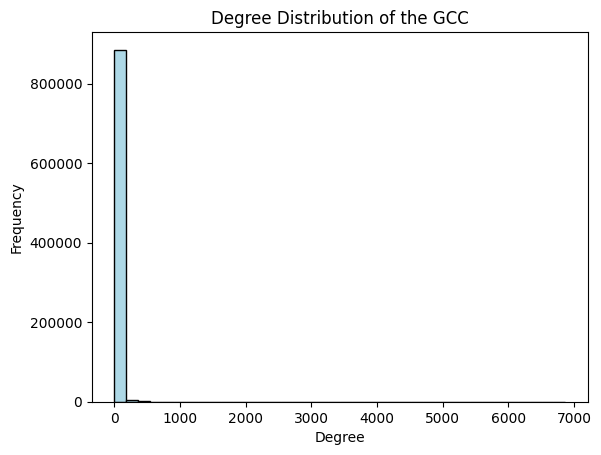

In [ ]:
# degree distribution in a histogram
plt.hist(degrees_GC, bins=38, color='lightblue', edgecolor='black')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of the GCC')
plt.show()

Highly skewed with many friends having very few friends

Although we have drastically cut down on the graph by only keeping the greatest component, it is still way too large to plot, thus we take 5000 random nodes and plot them just to get some visual

In [ ]:
# select 30000 random nodes
"""
random.seed(SEED)
sampled_nodes = random.sample(list(G.nodes()), 30000)
H = G.subgraph(sampled_nodes).copy()

with open('data/processed/yelp_graph_H.pkl', 'wb') as f:
    pickle.dump(H, f)
print("✓ Saved graph H")
"""

✓ Saved graph H


In [67]:
H = pickle.load(open('data/processed/yelp_graph_H.pkl', 'rb'))

In [56]:
number_of_nodes_full_network = H.number_of_nodes()
number_of_edges_full_network = H.number_of_edges()
print(f'Number of nodes in the graph: {number_of_nodes_full_network}')
print(f'Number of edges in the graph: {number_of_edges_full_network}')

Number of nodes in the graph: 30000
Number of edges in the graph: 8551


In [57]:
# taking the greatest component
Hcc = sorted(nx.connected_components(G=H), key=len, reverse=True)
H = H.subgraph(Hcc[0])

In [58]:
number_of_nodes_full_network = H.number_of_nodes()
number_of_edges_full_network = H.number_of_edges()
print(f'Number of nodes in the graph: {number_of_nodes_full_network}')
print(f'Number of edges in the graph: {number_of_edges_full_network}')

Number of nodes in the graph: 4132
Number of edges in the graph: 6003


In [59]:
degrees_HC = [H.degree(node) for node in H.nodes()]
print(f'Average degree: {sum(degrees_HC)/H.number_of_nodes()}')
print(f'Highest degree: {max(degrees_HC)}')
print(f'Lowest degree: {min(degrees_HC)}')

Average degree: 2.905614714424008
Highest degree: 147
Lowest degree: 1


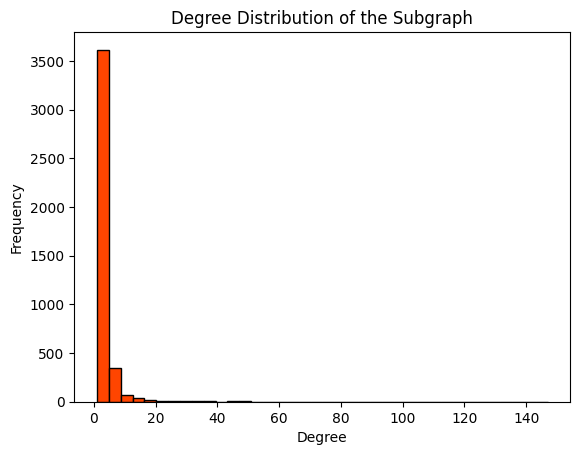

In [ ]:
# degree distribution in a histogram
plt.hist(degrees_HC, bins=38, color='orangered', edgecolor='black')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of the Subgraph')
plt.savefig("figures/yelp_user_friendship_degree_distribution_subgraph.svg", dpi=300)
plt.show()

Highly skewed degree distribution, with many nodes not having many friends. Just as with the full network.

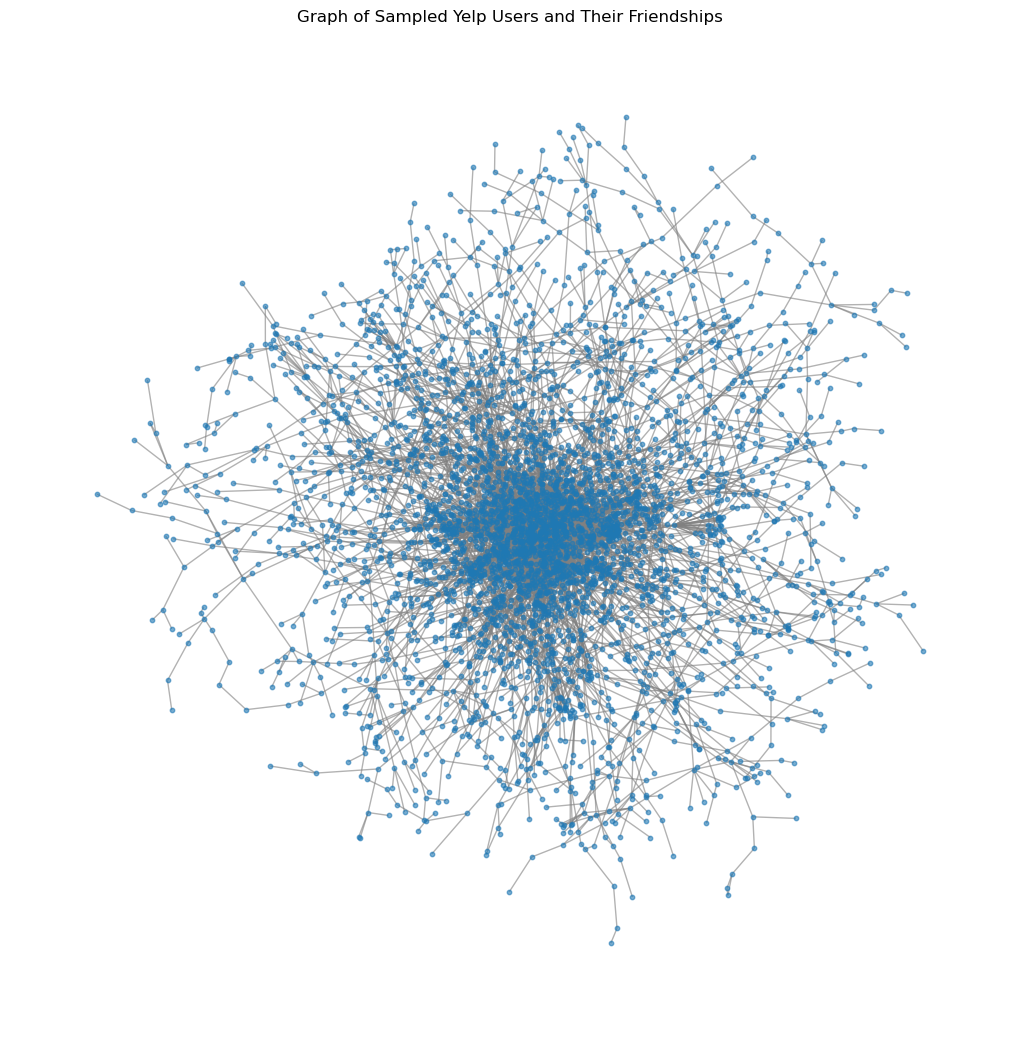

In [25]:
plt.figure(figsize=(10, 10))
nx.draw(H, node_size=10, alpha=0.6, edge_color="gray", with_labels=False)
plt.title("Graph of Sampled Yelp Users and Their Friendships")
plt.savefig("figures/yelp_user_friendship_graph.svg", dpi=300)
plt.show()

In [ ]:
# making the graph to dict to work with it
graph_dict = nx.to_dict_of_lists(H)

In [87]:
"""
sorted_betweenness = sorted(betweenness_centrality_normalized(graph_dict).items(), key=lambda x: x[1], reverse=True)
print("Top 10 users by betweenness centrality:")
for user, centrality in sorted_betweenness[:10]:
    print(f'User ID: {user}, Betweenness Centrality: {centrality}')

sorted_betweenness = dict(sorted_betweenness)
"""

Top 10 users by betweenness centrality:
User ID: djxnI8Ux8ZYQJhiOQkrRhA, Betweenness Centrality: 0.17624815059183707
User ID: uIjj7EIVBU4kGNgmKPO02A, Betweenness Centrality: 0.1453045998841232
User ID: r3ov7FgibBx41_W74I1KiA, Betweenness Centrality: 0.08741732950571851
User ID: INxvh4Rixsdfzh6PcWc_pw, Betweenness Centrality: 0.07375305092937708
User ID: SRd7-3R8jG_WHAS5C4BfaQ, Betweenness Centrality: 0.06530469808859558
User ID: TL-wgAhbdROaC4b-DA8-7Q, Betweenness Centrality: 0.054233384866428425
User ID: oygdh1nR-FyWsqP7ajoTvw, Betweenness Centrality: 0.05337731914642875
User ID: tJIzUxwfaLDwO6R6wSZ9vw, Betweenness Centrality: 0.05277453588220559
User ID: jt49xjEjQisu6wTTGn6B3A, Betweenness Centrality: 0.05197145358820639
User ID: C6LV0p8L6IfBfh1YFRkWzQ, Betweenness Centrality: 0.051165107178772484


In [ ]:
# save to csv to be able to recreate
"""
betweenness_df = pd.DataFrame.from_dict(sorted_betweenness, orient='index', columns=['betweenness_centrality'])
betweenness_df.index.name = 'user_id'
betweenness_df.to_csv('data/processed/yelp_betweenness_centrality.csv')
"""

In [62]:
betweenness_df = pd.read_csv('data/processed/yelp_betweenness_centrality.csv', index_col='user_id')
sorted_betweenness = betweenness_df['betweenness_centrality'].to_dict()

In [29]:
# Comparing to the built-in function
"""
betweenness_centrality_built_in = nx.betweenness_centrality(H)
sorted_betweenness_built_in = sorted(betweenness_centrality_built_in.items(), key=lambda x: x[1], reverse=True)
print("Top 10 users by betweenness centrality (built-in):")
for user, centrality in sorted_betweenness_built_in[:10]:
    print(f'User ID: {user}, Betweenness Centrality: {centrality}')
"""

'\nbetweenness_centrality_built_in = nx.betweenness_centrality(H)\nsorted_betweenness_built_in = sorted(betweenness_centrality_built_in.items(), key=lambda x: x[1], reverse=True)\nprint("Top 10 users by betweenness centrality (built-in):")\nfor user, centrality in sorted_betweenness_built_in[:10]:\n    print(f\'User ID: {user}, Betweenness Centrality: {centrality}\')\n'

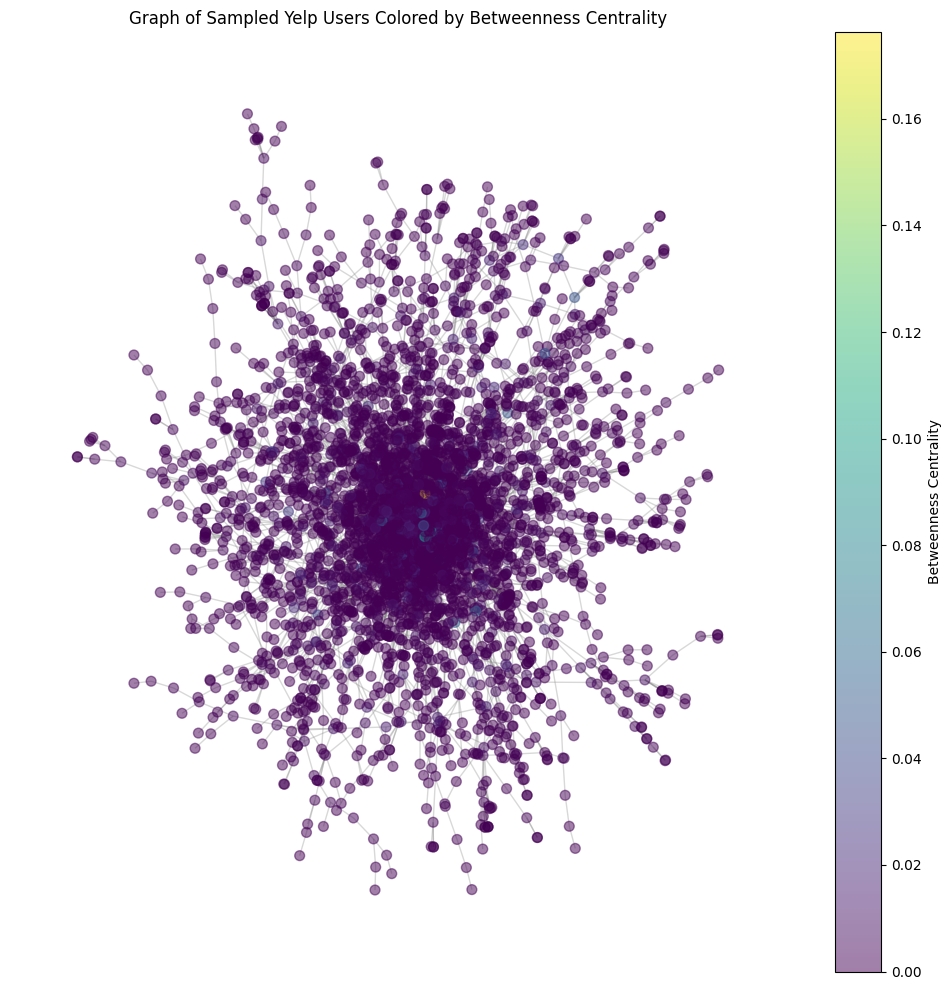

In [ ]:
# Change to the manual calculation
node_colors = [sorted_betweenness[n] for n in H.nodes()]

pos = nx.spring_layout(H, seed=SEED)

fig, ax = plt.subplots(figsize=(10, 10))

nodes = nx.draw_networkx_nodes(
    H, pos, ax=ax,
    node_size=50,
    node_color=node_colors,
    cmap=plt.cm.viridis,
    alpha=0.5
)
nx.draw_networkx_edges(H, pos, ax=ax, edge_color="gray", alpha=0.3)

ax.set_title("Graph of Sampled Yelp Users Colored by Betweenness Centrality")
ax.set_axis_off()

cbar = fig.colorbar(nodes, ax=ax)
cbar.set_label("Betweenness Centrality")

plt.tight_layout()
plt.savefig("figures/yelp_user_friendship_betweenness_centrality.svg", dpi=300)
plt.show()

The nodes with highest betweenness is in the middle which does make sense as they are most likely on most of the shortest paths.

In [ ]:
"""
mods = {}
for k in range(30, 50):
    labels = spectral_clustering(graph_dict, k)
    communities = {}
    for node, lbl in labels.items():
        communities.setdefault(lbl, []).append(node)
    mods[k] = modularity(H, communities.values())

print(mods)
print("Optimal number of clusters (k) based on highest modularity:", max(mods, key=mods.get))
"""

{30: 0.35784138859550174, 31: 0.3140518696174152, 32: 0.35870140336572787, 33: 0.3599850499537838, 34: 0.36667877122574805, 35: 0.3466155339233043, 36: 0.35159757841108324, 37: 0.3451614050823443, 38: 0.3735820467799306, 39: 0.37540314189620727, 40: 0.38129667744283224, 41: 0.3457213866274704, 42: 0.37888744838530813, 43: 0.35285398835370485, 44: 0.39345018756100325, 45: 0.3695041118454599, 46: 0.38573416939706073, 47: 0.39811300968428537, 48: 0.41849287472427926, 49: 0.3942257590178756}
Optimal number of clusters (k) based on highest modularity: 48


In [65]:
# pickle the spectral communities
"""
with open('data/processed/yelp_spectral_communities.pkl', 'wb') as f:
    pickle.dump(communities, f)"""
    
with open('data/processed/yelp_spectral_communities.pkl', 'rb') as f:
    communities = pickle.load(f)

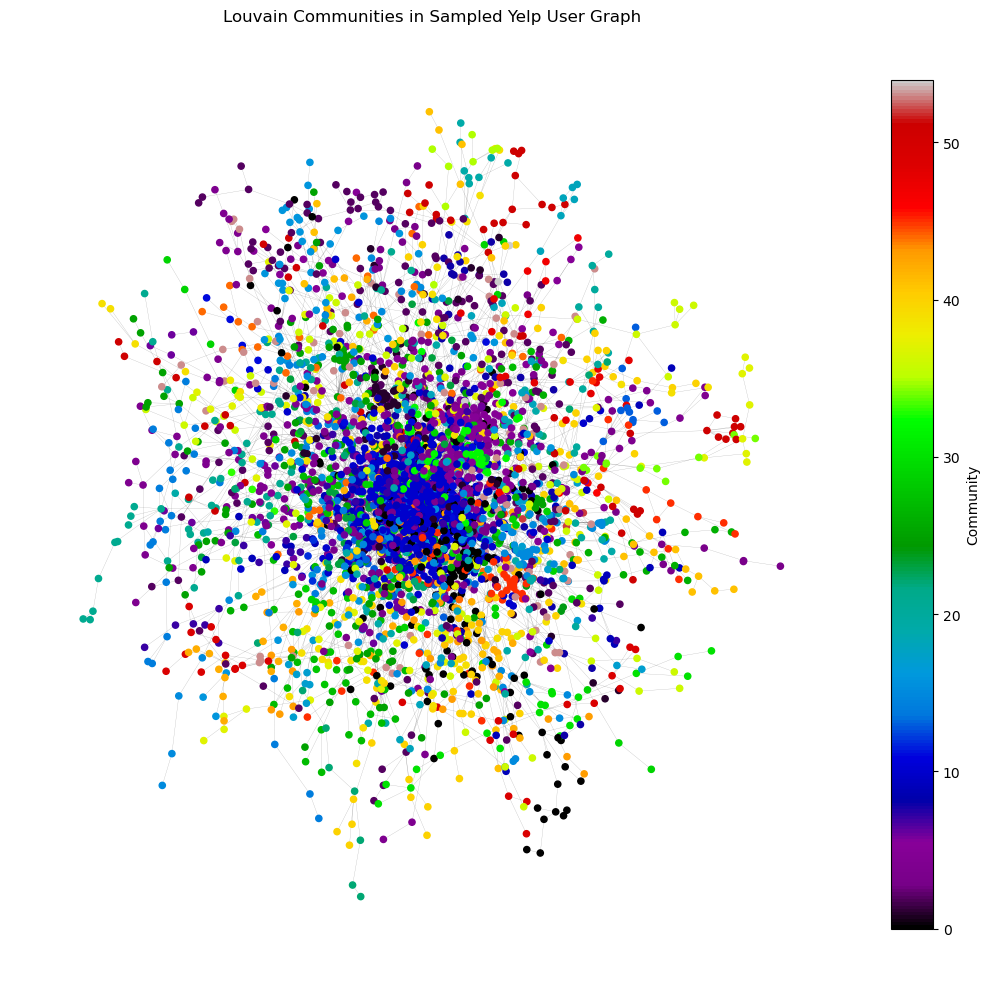

In [ ]:
"""# Louvain partition
partition = community_louvain.best_partition(H, random_state=SEED, randomize=False)

# Map community labels
com_ids = {c: i for i, c in enumerate(sorted(set(partition.values())))}
node_colors = [com_ids[partition[n]] for n in H.nodes()]
num_comms = len(com_ids)

pos = nx.spring_layout(H, seed=SEED)

fig, ax = plt.subplots(figsize=(10, 10))
nodes = nx.draw_networkx_nodes(
    H, pos, ax=ax,
    nodelist=list(H.nodes()),
    node_size=20,
    node_color=node_colors,
    cmap=plt.cm.tab20 if num_comms <= 20 else plt.cm.viridis
)
nx.draw_networkx_edges(H, pos, ax=ax, alpha=0.3, width=0.2)

# Colormap for better distinction between communities
nodes.set_cmap(plt.cm.tab20b if num_comms <= 20 else plt.cm.nipy_spectral)
ax.set_title("Louvain Communities in Sampled Yelp User Graph")
ax.set_axis_off()

cbar = fig.colorbar(nodes, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Community")
if num_comms <= 20:
    cbar.set_ticks(range(num_comms))
    cbar.set_ticklabels(range(num_comms))

plt.tight_layout()
plt.savefig("figures/yelp_user_friendship_louvain_communities.svg", dpi=300)
plt.show()
"""

In above we see all the communities in one graph. It is however really hard to tell anything from this.

In [ ]:
"""
sizes = pd.Series(list(partition.values())).value_counts()
# number of communities
num_communities = len(sizes)
print(f'Number of communities detected by Louvain method: {num_communities}')
comms = {}
for n,c in partition.items():
    comms.setdefault(c, []).append(n)

modularity_score = modularity(H, comms.values())
print(modularity_score)
"""

Number of communities detected by Louvain method: 55
0.7691229625345026


Better modularity for Louvain communities, thus we want to work with this

In [62]:
# pickle the communities
"""
with open('data/processed/yelp_louvain_communities.pkl', 'wb') as f:
    pickle.dump(partition, f)
"""

with open('data/processed/yelp_louvain_communities.pkl', 'rb') as f:
    partition = pickle.load(f)

In [63]:
# user_ids in community 6
users_in_community_6 = [node for node, comm in partition.items() if comm == 6]
print(f'User IDs in community 6: {users_in_community_6}')

User IDs in community 6: ['jPBKGmxgfG5iRipd3v7BAw', 'wuT2zH7Atq-98BirpB-8Aw', '5OZvqngWSRvdMeQQRkwzLw', 'UOAq6-YRLoIgWtJNkChzbA', 'V9doxrjqG6S94V9WpHGr7w', 'bbxczHvKDVJbx8G6KyeCaQ', 'h5kN9PDhS3XJ7toa3PVJ9Q', 'mcXs_mV5CQHhlUZsRVvtXA', 'LhZLS33umZG20LfyEftYeQ', 'UGTQum1peLSeOZr08LERbA', '4-Oh0TN8-b9gj12_VUZmAw', 'pZioOLzVNpxyEVchL6LLsQ', '2x4SFLumawQPPzYcx6v_7Q', 'yhyjGxcZ3ypdg_470CCgKw', 'LOK4oCby0Ou46W65YMO6-w', 'R5r52e3EnFDStcztaN_eFg', '1eQcZZWwGMv45rkjRepNaA', 'cuIGSOIcsYdhcf16oy7RiQ', 'GX_lTNelZdEDx2XF8ECrQQ', 'q3zGja1DWAr5X3FRzLLrrQ', 'w84Uv36jWR5bZwEUUIH_2A', 'uOI4jHuwN-XJvd6zkMBtRQ', 'B9wxFyA_Fkr4b2GTdX3uNw', 'OSssus6Lt58zVRdcB-nlWg', 'sAbHdUgrjMOiQQLNh0H0YQ', 'ZJ6sj1IjdwmPPL_ZxmRKgw', 'ZOjaV7oALZrBMznTxhfIWA', 'F4Abg96un5mT019hdstmVA', 'VzPkbXNATe_7f5CLCtqyPA', 'c_YjHxlnDARw6UothG05sg', '8OVF-4kKZZNMXX_vuYiPQw', 'npaqVmBLp_bRk4DcraZYww', 'HMUnp55Q8_vxIEPl1V0W_g', 'Sm8Vc5ebaw4CRooUKlvv6Q', 'qv9Ke7SBcg4j8lHkcPK2LA', '67UFw_MqwDC_XF5bwhqF5Q', 'vl-GujIYlPJfC-fHz-5xVg', '1VdMQhgS18-

In [64]:
sizes = pd.Series(list(partition.values())).value_counts()
print(sizes)

10    633
5     224
0     207
4     203
3     190
2     177
15    159
9     157
25    139
40    107
1     107
36    100
37     88
16     87
32     82
19     76
39     75
53     75
7      72
8      70
45     65
21     65
41     63
27     63
23     60
51     57
14     57
29     55
42     51
13     51
26     51
44     50
6      48
11     48
17     41
18     38
22     38
43     36
49     28
20     26
30     21
48     17
34     14
35     10
50      7
28      6
47      6
12      5
54      5
38      4
46      4
31      4
33      4
52      3
24      3
Name: count, dtype: int64


In [65]:
# user_ids in community 6
users_in_community_6 = [node for node, comm in partition.items() if comm == 6]
print(f'User IDs in community 6: {users_in_community_6}')

User IDs in community 6: ['jPBKGmxgfG5iRipd3v7BAw', 'wuT2zH7Atq-98BirpB-8Aw', '5OZvqngWSRvdMeQQRkwzLw', 'UOAq6-YRLoIgWtJNkChzbA', 'V9doxrjqG6S94V9WpHGr7w', 'bbxczHvKDVJbx8G6KyeCaQ', 'h5kN9PDhS3XJ7toa3PVJ9Q', 'mcXs_mV5CQHhlUZsRVvtXA', 'LhZLS33umZG20LfyEftYeQ', 'UGTQum1peLSeOZr08LERbA', '4-Oh0TN8-b9gj12_VUZmAw', 'pZioOLzVNpxyEVchL6LLsQ', '2x4SFLumawQPPzYcx6v_7Q', 'yhyjGxcZ3ypdg_470CCgKw', 'LOK4oCby0Ou46W65YMO6-w', 'R5r52e3EnFDStcztaN_eFg', '1eQcZZWwGMv45rkjRepNaA', 'cuIGSOIcsYdhcf16oy7RiQ', 'GX_lTNelZdEDx2XF8ECrQQ', 'q3zGja1DWAr5X3FRzLLrrQ', 'w84Uv36jWR5bZwEUUIH_2A', 'uOI4jHuwN-XJvd6zkMBtRQ', 'B9wxFyA_Fkr4b2GTdX3uNw', 'OSssus6Lt58zVRdcB-nlWg', 'sAbHdUgrjMOiQQLNh0H0YQ', 'ZJ6sj1IjdwmPPL_ZxmRKgw', 'ZOjaV7oALZrBMznTxhfIWA', 'F4Abg96un5mT019hdstmVA', 'VzPkbXNATe_7f5CLCtqyPA', 'c_YjHxlnDARw6UothG05sg', '8OVF-4kKZZNMXX_vuYiPQw', 'npaqVmBLp_bRk4DcraZYww', 'HMUnp55Q8_vxIEPl1V0W_g', 'Sm8Vc5ebaw4CRooUKlvv6Q', 'qv9Ke7SBcg4j8lHkcPK2LA', '67UFw_MqwDC_XF5bwhqF5Q', 'vl-GujIYlPJfC-fHz-5xVg', '1VdMQhgS18-

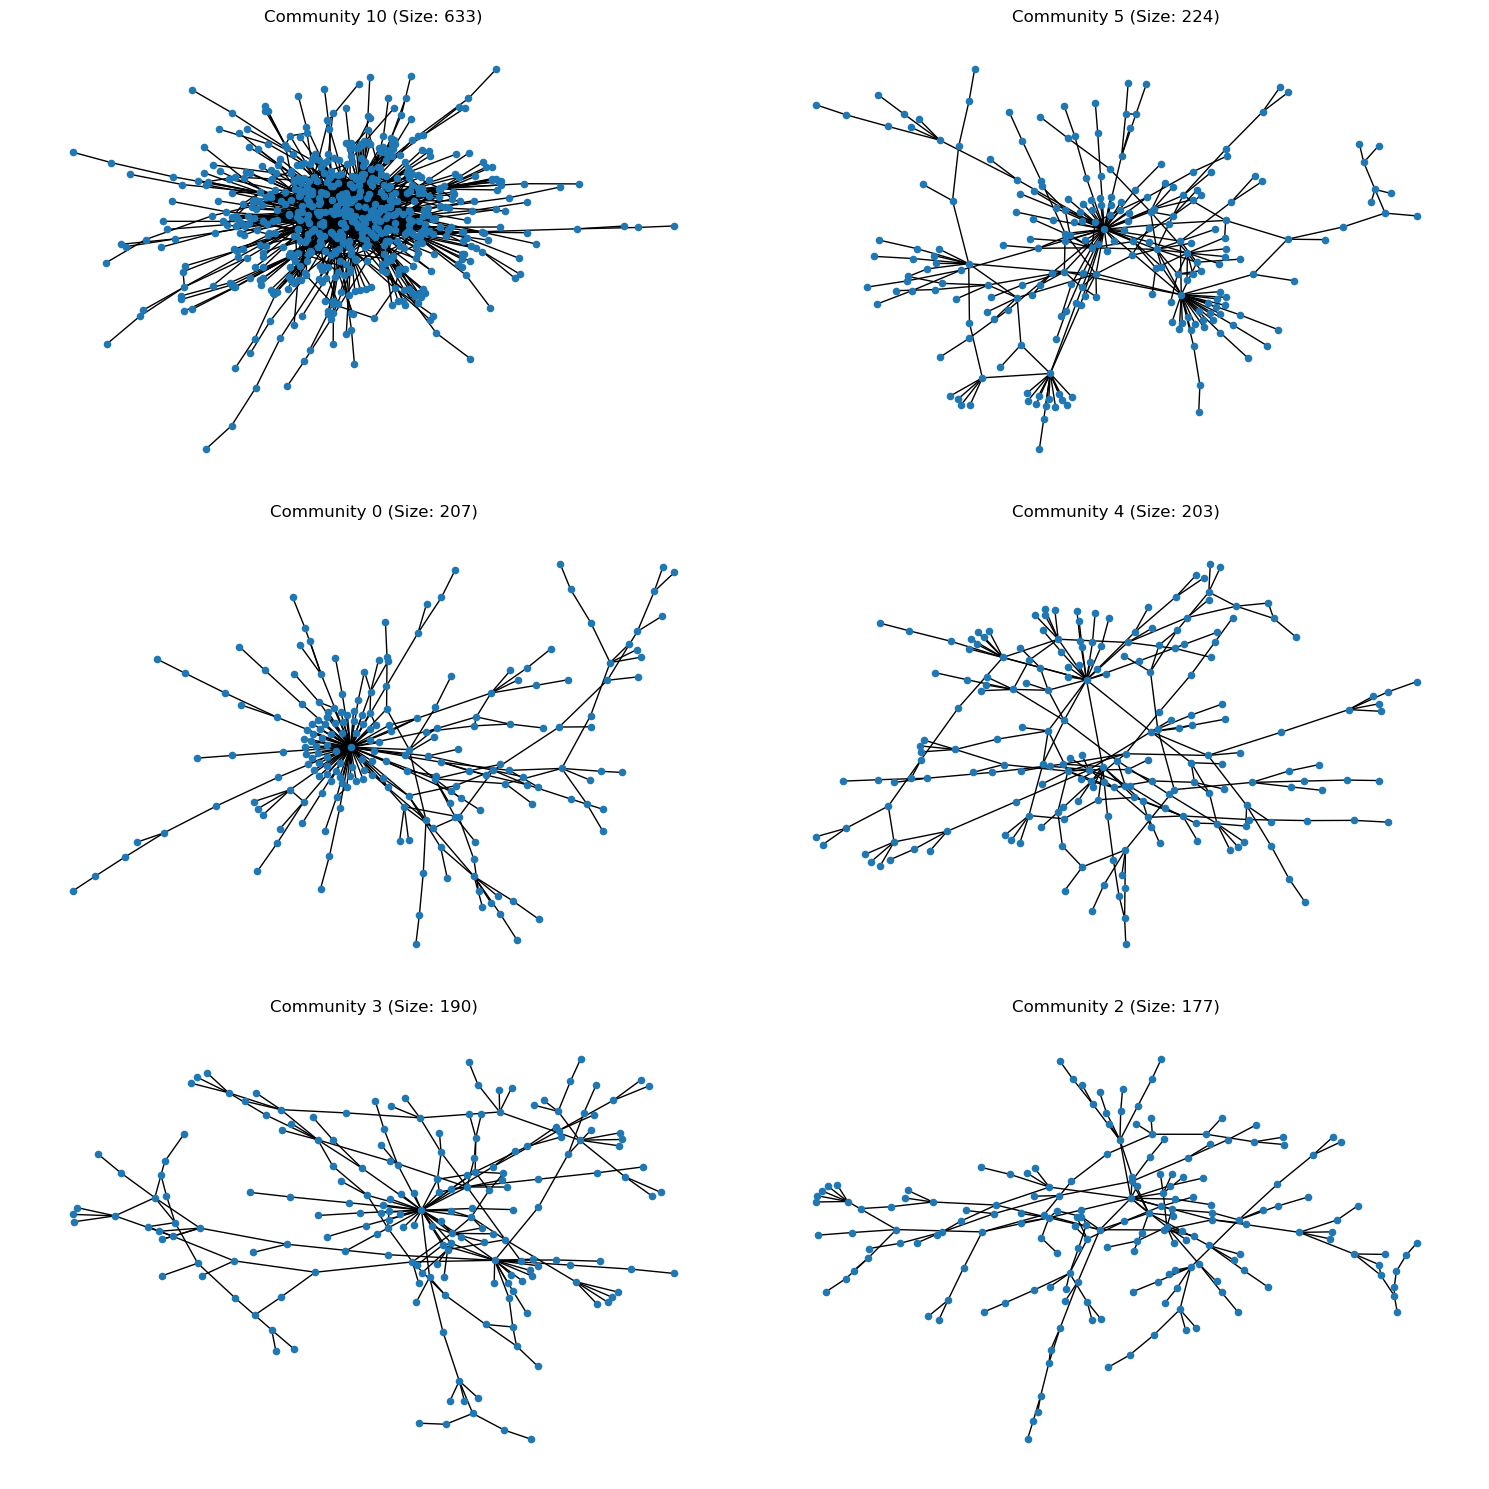

In [68]:
top_6_communities = sizes.index[:6]

plt.figure(figsize=(15, 15))
for i, community in enumerate(top_6_communities, 1):
    nodes = [n for n, c in partition.items() if c == community]
    sub = H.subgraph(nodes)
    plt.subplot(3, 2, i)
    nx.draw(sub, with_labels=False, node_size=20)
    plt.title(f'Community {community} (Size: {sizes[community]})')

plt.tight_layout()
plt.savefig("figures/yelp_user_friendship_top6_communities.svg", dpi=300)
plt.show()


In [69]:
p = Path("data/processed/yelp_louvain_communities.pkl")
print("exists:", p.exists())
print("size:", p.stat().st_size if p.exists() else None)


exists: True
size: 111597


In [70]:
user_community_df = pd.DataFrame(
    [(node, comm) for node, comm in partition.items()],
    columns=["user_id", "community"]
)

# save as csv
user_community_df.to_csv(DATA_DIR_PROC / "yelp_user_communities.csv", index=False)

# Apriori on the communities 

In [71]:
# size of the communities
sizes = pd.Series(list(partition.values())).value_counts()

# Top 6 largest communities
top_6_communities = sizes.index[:6].tolist()
print(f"Top 6 communities (by size): {top_6_communities}")
print(f"Sizes: {sizes[top_6_communities].tolist()}")

Top 6 communities (by size): [10, 5, 0, 4, 3, 2]
Sizes: [633, 224, 207, 203, 190, 177]


In [72]:
# Create a mapping: user_id -> community_id
user_to_community = partition  # This is already user_id -> community_id

# Get user sets for each community
top_6_users = {
    comm: set([user for user, c in partition.items() if c == comm])
    for comm in top_6_communities
}

In [73]:
def filter_baskets_by_community(baskets_df, user_ids_set):
    """Filter baskets to only include users in the given set"""
    filtered = baskets_df[baskets_df['user_id'].isin(user_ids_set)].copy()
    return filtered

# Load original baskets
liked_baskets = pd.read_parquet("data/processed/baskets_liked_ids.parquet")
hated_baskets = pd.read_parquet("data/processed/baskets_hated_ids.parquet")

# Filter for each community
communities_to_analyze = {
    **{f"top_{i+1}": (comm, top_6_users[comm]) for i, comm in enumerate(top_6_communities)}
}

filtered_data = {}
for name, (comm_id, user_set) in communities_to_analyze.items():
    filtered_data[name] = {
        'community_id': comm_id,
        'liked': filter_baskets_by_community(liked_baskets, user_set),
        'hated': filter_baskets_by_community(hated_baskets, user_set)
    }
    print(f"{name} (comm {comm_id}): {len(filtered_data[name]['liked'])} liked baskets, {len(filtered_data[name]['hated'])} hated baskets")

top_1 (comm 10): 251 liked baskets, 58 hated baskets
top_2 (comm 5): 98 liked baskets, 33 hated baskets
top_3 (comm 0): 96 liked baskets, 34 hated baskets
top_4 (comm 4): 62 liked baskets, 24 hated baskets
top_5 (comm 3): 70 liked baskets, 18 hated baskets
top_6 (comm 2): 43 liked baskets, 7 hated baskets


In [75]:
def filter_baskets_by_community(baskets_df, user_ids_set):
    """Filter baskets to only include users in the given set"""
    return baskets_df[baskets_df["user_id"].isin(user_ids_set)].copy()

COMM_DIR = DATA_DIR_PROC / "baskets_by_community"
COMM_DIR.mkdir(parents=True, exist_ok=True)

COMM_THRESHOLDS = {
    "top_1": {"min_support": 0.06, "min_conf": 0.6},
    "top_2": {"min_support": 0.1, "min_conf": 0.6},
    "top_3": {"min_support": 0.1, "min_conf": 0.6},
    "top_4": {"min_support": 0.196, "min_conf": 0.6},
    "top_5": {"min_support": 0.066, "min_conf": 0.6},
    "top_6": {"min_support": 0.066, "min_conf": 0.6},
}

cols_decoded = ["Antecedent", "Consequent", "Antecedent_decoded", "Consequent_decoded",
                "Support", "Confidence", "Lift"]

for name, (comm_id, user_set) in communities_to_analyze.items():
    print(f"\nCommunity {name} (ID {comm_id})")

    liked_comm = filter_baskets_by_community(liked_baskets, user_set)
    hated_comm = filter_baskets_by_community(hated_baskets, user_set)

    liked_path = COMM_DIR / f"baskets_liked_{name}_comm{comm_id}.parquet"
    hated_path = COMM_DIR / f"baskets_hated_{name}_comm{comm_id}.parquet"

    liked_comm.to_parquet(liked_path, index=False)
    hated_comm.to_parquet(hated_path, index=False)
    
    threashold = COMM_THRESHOLDS.get(name, {"min_support": 0.02, "min_conf": 0.4})
    MIN_SUPPORT = threashold["min_support"]
    MIN_CONF    = threashold["min_conf"]

    df_rules_liked_comm, _ = ap.run_apriori(
        f"{name}_liked", liked_path, MIN_SUPPORT, MIN_CONF, OUT_DIR, id2cat_map
    )
    df_rules_hated_comm, _ = ap.run_apriori(
        f"{name}_hated", hated_path, MIN_SUPPORT, MIN_CONF, OUT_DIR, id2cat_map
    )


Community top_1 (ID 10)
Running Apriori for top_1_liked
Generated 258 top_1_liked rules
Saved 258 top_1_liked rules
Running Apriori for top_1_hated
Generated 1286 top_1_hated rules
Saved 1286 top_1_hated rules

Community top_2 (ID 5)
Running Apriori for top_2_liked
Generated 1206 top_2_liked rules
Saved 1206 top_2_liked rules
Running Apriori for top_2_hated
Generated 3 top_2_hated rules
Saved 3 top_2_hated rules

Community top_3 (ID 0)
Running Apriori for top_3_liked
Generated 986 top_3_liked rules
Saved 986 top_3_liked rules
Running Apriori for top_3_hated
Generated 10 top_3_hated rules
Saved 10 top_3_hated rules

Community top_4 (ID 4)
Running Apriori for top_4_liked
Generated 45 top_4_liked rules
Saved 45 top_4_liked rules
Running Apriori for top_4_hated
Generated 3 top_4_hated rules
Saved 3 top_4_hated rules

Community top_5 (ID 3)
Running Apriori for top_5_liked
Generated 333 top_5_liked rules
Saved 333 top_5_liked rules
Running Apriori for top_5_hated
Generated 1107 top_5_hated 

In [76]:
# Load community rules from parquet files to preserve tuple data types
rules_top1_liked = pd.read_parquet(OUT_DIR / "rules_top_1_liked.parquet")
rules_top1_hated = pd.read_parquet(OUT_DIR / "rules_top_1_hated.parquet")
rules_top2_liked = pd.read_parquet(OUT_DIR / "rules_top_2_liked.parquet")
rules_top2_hated = pd.read_parquet(OUT_DIR / "rules_top_2_hated.parquet")
rules_top3_liked = pd.read_parquet(OUT_DIR / "rules_top_3_liked.parquet")
rules_top3_hated = pd.read_parquet(OUT_DIR / "rules_top_3_hated.parquet")
rules_top4_liked = pd.read_parquet(OUT_DIR / "rules_top_4_liked.parquet")
rules_top4_hated = pd.read_parquet(OUT_DIR / "rules_top_4_hated.parquet")
rules_top5_liked = pd.read_parquet(OUT_DIR / "rules_top_5_liked.parquet")
rules_top5_hated = pd.read_parquet(OUT_DIR / "rules_top_5_hated.parquet")
rules_top6_liked = pd.read_parquet(OUT_DIR / "rules_top_6_liked.parquet")
rules_top6_hated = pd.read_parquet(OUT_DIR / "rules_top_6_hated.parquet")


rules_top_1_filtered_liked = filter_rules(rules_top1_liked, min_support=0.02, min_confidence=0.5, min_lift=2, max_antecedent=3, color="Greens", save_path="figures/rules_top1_liked_filtered.html")
rules_top_1_filtred_hated = filter_rules(rules_top1_hated, min_support=0.012, min_confidence=0.4, min_lift=1.6, max_antecedent=3, color="Reds", save_path="figures/rules_top1_hated_filtered.html")
rules_top_2_filtered_liked = filter_rules(rules_top2_liked, min_support=0.02, min_confidence=0.5, min_lift=2, max_antecedent=3, color="Greens", save_path="figures/rules_top2_liked_filtered.html")
rules_top_2_filtred_hated = filter_rules(rules_top2_hated, min_support=0.012, min_confidence=0.4, min_lift=1.6, max_antecedent=3, color="Reds", save_path="figures/rules_top2_hated_filtered.html")
rules_top_3_filtered_liked = filter_rules(rules_top3_liked, min_support=0.02, min_confidence=0.5, min_lift=2, max_antecedent=3, color="Greens", save_path="figures/rules_top3_liked_filtered.html")
rules_top_3_filtred_hated = filter_rules(rules_top3_hated, min_support=0.012, min_confidence=0.4, min_lift=1.6, max_antecedent=3, color="Reds", save_path="figures/rules_top3_hated_filtered.html")
rules_top_4_filtered_liked = filter_rules(rules_top4_liked, min_support=0.02, min_confidence=0.5, min_lift=2, max_antecedent=3, color="Greens", save_path="figures/rules_top4_liked_filtered.html")
rules_top_4_filtred_hated = filter_rules(rules_top4_hated, min_support=0.012, min_confidence=0.4, min_lift=1.6, max_antecedent=3, color="Reds", save_path="figures/rules_top4_hated_filtered.html")
rules_top_5_filtered_liked = filter_rules(rules_top5_liked, min_support=0.02, min_confidence=0.5, min_lift=2, max_antecedent=3, color="Greens", save_path="figures/rules_top5_liked_filtered.html")
rules_top_5_filtred_hated = filter_rules(rules_top5_hated, min_support=0.012, min_confidence=0.4, min_lift=1.6, max_antecedent=3, color="Reds", save_path="figures/rules_top5_hated_filtered.html")
rules_top_6_filtered_liked = filter_rules(rules_top6_liked, min_support=0.02, min_confidence=0.5, min_lift=2, max_antecedent=3, color="Greens", save_path="figures/rules_top6_liked_filtered.html")
rules_top_6_filtred_hated = filter_rules(rules_top6_hated, min_support=0.012, min_confidence=0.4, min_lift=1.6, max_antecedent=3, color="Reds", save_path="figures/rules_top6_hated_filtered.html")


## Investigating the rules for communities 

### Community 1: Liked categories and hated categories

In [77]:
rules_top1_liked_lift = (
    rules_top1_liked
    .sort_values(["Lift"], ascending=False)
    .head(5)
)
num_cols = ["Support", "Confidence", "Lift"]
rules_top1_liked_lift.style \
    .format({c: "{:.4f}" for c in num_cols}) \
    .background_gradient(cmap=cm.Greens, subset=num_cols)

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
0,[ 19 149],[ 3 43],0.0637,0.9412,5.7618,['Breakfast & Brunch' 'Salad'],['American (New)' 'Coffee & Tea']
1,[ 19 104],[ 4 43],0.0637,0.6957,5.6325,['Breakfast & Brunch' 'Italian'],['American (Traditional)' 'Coffee & Tea']
2,[ 43 104],[ 4 19],0.0637,0.7619,5.4639,['Coffee & Tea' 'Italian'],['American (Traditional)' 'Breakfast & Brunch']
3,[ 3 149],[19 43],0.0637,0.7619,5.3122,['American (New)' 'Salad'],['Breakfast & Brunch' 'Coffee & Tea']
4,[ 19 121],[ 4 43],0.0637,0.6400,5.1819,['Breakfast & Brunch' 'Mexican'],['American (Traditional)' 'Coffee & Tea']


In [78]:
rules_top1_hated_lift = (
    rules_top1_hated
    .sort_values(["Lift"], ascending=False)
    .head(5)
)
num_cols = ["Support", "Confidence", "Lift"]
rules_top1_hated_lift.style \
    .format({c: "{:.4f}" for c in num_cols}) \
    .background_gradient(cmap=cm.Reds, subset=num_cols)

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
0,[ 3 4 25 151],[138 155],0.0690,1.0000,14.5000,['American (New)' 'American (Traditional)' 'Burgers' 'Sandwiches'],['Pizza' 'Seafood']
1,[ 3 138 151 155],[ 4 25],0.0690,1.0000,14.5000,['American (New)' 'Pizza' 'Sandwiches' 'Seafood'],['American (Traditional)' 'Burgers']
2,[ 3 138 155],[ 4 25 151],0.0690,1.0000,14.5000,['American (New)' 'Pizza' 'Seafood'],['American (Traditional)' 'Burgers' 'Sandwiches']
3,[ 3 4 25],[138 151 155],0.0690,1.0000,14.5000,['American (New)' 'American (Traditional)' 'Burgers'],['Pizza' 'Sandwiches' 'Seafood']
4,[ 4 25 151],[ 3 138 155],0.0690,1.0000,14.5000,['American (Traditional)' 'Burgers' 'Sandwiches'],['American (New)' 'Pizza' 'Seafood']


### Community 2: Liked categories and hated categories

In [79]:
rules_top2_liked_lift = (
    rules_top2_liked
    .sort_values(["Lift"], ascending=False)
    .head(5)
)
num_cols = ["Support", "Confidence", "Lift"]
rules_top2_liked_lift.style \
    .format({c: "{:.4f}" for c in num_cols}) \
    .background_gradient(cmap=cm.Greens, subset=num_cols)

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
0,[ 3 31 151],[ 4 19 121],0.1020,0.7143,6.3636,['American (New)' 'Cajun/Creole' 'Sandwiches'],['American (Traditional)' 'Breakfast & Brunch' 'Mexican']
1,[ 4 121],[ 3 31 151],0.1020,0.9091,6.3636,['American (Traditional)' 'Mexican'],['American (New)' 'Cajun/Creole' 'Sandwiches']
2,[ 3 31 151],[ 4 121],0.1020,0.7143,6.3636,['American (New)' 'Cajun/Creole' 'Sandwiches'],['American (Traditional)' 'Mexican']
3,[ 4 19 121],[ 3 31 151],0.1020,0.9091,6.3636,['American (Traditional)' 'Breakfast & Brunch' 'Mexican'],['American (New)' 'Cajun/Creole' 'Sandwiches']
4,[ 4 121],[ 3 19 31 151],0.1020,0.9091,6.3636,['American (Traditional)' 'Mexican'],['American (New)' 'Breakfast & Brunch' 'Cajun/Creole' 'Sandwiches']


In [80]:
rules_top2_hated_lift = (
    rules_top2_hated
    .sort_values(["Lift"], ascending=False)
    .head(5)
)
num_cols = ["Support", "Confidence", "Lift"]
rules_top2_hated_lift.style \
    .format({c: "{:.4f}" for c in num_cols}) \
    .background_gradient(cmap=cm.Reds, subset=num_cols)

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
0,[155],[121],0.1212,1.0000,3.6667,['Seafood'],['Mexican']
1,[25],[121],0.1212,0.8000,2.9333,['Burgers'],['Mexican']
2,[193],[4],0.1212,0.8000,2.0308,['Vegetarian'],['American (Traditional)']


### Community 3 : Liked categories and hated categories

In [81]:
rules_top3_liked_lift = (
    rules_top3_liked
    .sort_values(["Lift"], ascending=False)
    .head(5)
)
num_cols = ["Support", "Confidence", "Lift"]
rules_top3_liked_lift.style \
    .format({c: "{:.4f}" for c in num_cols}) \
    .background_gradient(cmap=cm.Greens, subset=num_cols)

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
0,[ 3 19],[ 4 97 121],0.1042,0.7143,6.2338,['American (New)' 'Breakfast & Brunch'],['American (Traditional)' 'Ice Cream & Frozen Yogurt' 'Mexican']
1,[ 4 97 121],[ 3 19],0.1042,0.9091,6.2338,['American (Traditional)' 'Ice Cream & Frozen Yogurt' 'Mexican'],['American (New)' 'Breakfast & Brunch']
2,[11 43],[ 3 40],0.1042,0.8333,6.1538,['Bakeries' 'Coffee & Tea'],['American (New)' 'Chinese']
3,[ 3 40],[11 43],0.1042,0.7692,6.1538,['American (New)' 'Chinese'],['Bakeries' 'Coffee & Tea']
4,[ 3 4 19],[ 97 121],0.1042,0.7692,6.1538,['American (New)' 'American (Traditional)' 'Breakfast & Brunch'],['Ice Cream & Frozen Yogurt' 'Mexican']


In [82]:
rules_top3_hated_lift = (
    rules_top3_hated
    .sort_values(["Lift"], ascending=False)
    .head(5)
)
num_cols = ["Support", "Confidence", "Lift"]
rules_top3_hated_lift.style \
    .format({c: "{:.4f}" for c in num_cols}) \
    .background_gradient(cmap=cm.Reds, subset=num_cols)

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
0,[ 4 104],[138],0.1176,1.0000,4.8571,['American (Traditional)' 'Italian'],['Pizza']
1,[3 4],[121],0.1176,0.8000,3.8857,['American (New)' 'American (Traditional)'],['Mexican']
2,[ 4 138],[104],0.1176,0.8000,3.8857,['American (Traditional)' 'Pizza'],['Italian']
3,[104 138],[4],0.1176,1.0000,3.0909,['Italian' 'Pizza'],['American (Traditional)']
4,[ 4 121],[3],0.1176,1.0000,2.8333,['American (Traditional)' 'Mexican'],['American (New)']


### Community 4: Liked categories and hated categories

In [83]:
rules_top4_liked_lift = (
    rules_top4_liked
    .sort_values(["Lift"], ascending=False)
    .head(5)
)
num_cols = ["Support", "Confidence", "Lift"]
rules_top4_liked_lift.style \
    .format({c: "{:.4f}" for c in num_cols}) \
    .background_gradient(cmap=cm.Greens, subset=num_cols)

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
0,[ 19 151],[29],0.2097,0.7647,2.9632,['Breakfast & Brunch' 'Sandwiches'],['Cafes']
1,[29],[ 19 151],0.2097,0.8125,2.9632,['Cafes'],['Breakfast & Brunch' 'Sandwiches']
2,[ 19 175],[4],0.2097,0.8667,2.6867,['Breakfast & Brunch' 'Sushi Bars'],['American (Traditional)']
3,[ 4 19],[175],0.2097,0.8667,2.6867,['American (Traditional)' 'Breakfast & Brunch'],['Sushi Bars']
4,[175],[ 4 19],0.2097,0.6500,2.6867,['Sushi Bars'],['American (Traditional)' 'Breakfast & Brunch']


In [84]:
rules_top4_hated_lift = (
    rules_top4_hated
    .sort_values(["Lift"], ascending=False)
    .head(5)
)
num_cols = ["Support", "Confidence", "Lift"]
rules_top4_hated_lift.style \
    .format({c: "{:.4f}" for c in num_cols}) \
    .background_gradient(cmap=cm.Reds, subset=num_cols)

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
0,[25],[151],0.2083,0.6250,2.1429,['Burgers'],['Sandwiches']
1,[151],[25],0.2083,0.7143,2.1429,['Sandwiches'],['Burgers']
2,[151],[121],0.2500,0.8571,1.8701,['Sandwiches'],['Mexican']


### Community 5: Liked categories and hated categories

In [85]:
rules_top5_liked_lift = (
    rules_top5_liked
    .sort_values(["Lift"], ascending=False)
    .head(5)
)
num_cols = ["Support", "Confidence", "Lift"]
rules_top5_liked_lift.style \
    .format({c: "{:.4f}" for c in num_cols}) \
    .background_gradient(cmap=cm.Greens, subset=num_cols)

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
0,[ 4 131],[ 3 121 155],0.0714,1.0000,14.0000,['American (Traditional)' 'Other'],['American (New)' 'Mexican' 'Seafood']
1,[ 3 121 155],[ 4 131],0.0714,1.0000,14.0000,['American (New)' 'Mexican' 'Seafood'],['American (Traditional)' 'Other']
2,[131 155],[ 3 4 121],0.0714,1.0000,11.6667,['Other' 'Seafood'],['American (New)' 'American (Traditional)' 'Mexican']
3,[121 131],[ 3 4 155],0.0714,1.0000,11.6667,['Mexican' 'Other'],['American (New)' 'American (Traditional)' 'Seafood']
4,[ 3 4 121],[131 155],0.0714,0.8333,11.6667,['American (New)' 'American (Traditional)' 'Mexican'],['Other' 'Seafood']


In [86]:
rules_top5_hated_lift = (
    rules_top5_hated
    .sort_values(["Lift"], ascending=False)
    .head(5)
)
num_cols = ["Support", "Confidence", "Lift"]
rules_top5_hated_lift.style \
    .format({c: "{:.4f}" for c in num_cols}) \
    .background_gradient(cmap=cm.Reds, subset=num_cols)

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
0,[ 3 4 43 53 81],[67],0.1111,1.0000,9.0000,['American (New)' 'American (Traditional)' 'Coffee & Tea' 'Delis' 'Gluten-Free'],['Fast Food']
1,[ 3 4 53 67],[43 81],0.1111,1.0000,9.0000,['American (New)' 'American (Traditional)' 'Delis' 'Fast Food'],['Coffee & Tea' 'Gluten-Free']
2,[ 3 4 67 81],[43 53],0.1111,1.0000,9.0000,['American (New)' 'American (Traditional)' 'Fast Food' 'Gluten-Free'],['Coffee & Tea' 'Delis']
3,[ 3 4 43 67],[53 81],0.1111,1.0000,9.0000,['American (New)' 'American (Traditional)' 'Coffee & Tea' 'Fast Food'],['Delis' 'Gluten-Free']
4,[43 53 81],[ 3 4 67],0.1111,1.0000,9.0000,['Coffee & Tea' 'Delis' 'Gluten-Free'],['American (New)' 'American (Traditional)' 'Fast Food']


### Community 6: Liked categories and hated categories

In [87]:
rules_top6_liked_lift = (
    rules_top6_liked
    .sort_values(["Lift"], ascending=False)
    .head(5)
)
num_cols = ["Support", "Confidence", "Lift"]
rules_top6_liked_lift.style \
    .format({c: "{:.4f}" for c in num_cols}) \
    .background_gradient(cmap=cm.Greens, subset=num_cols)

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
0,[155],[151],0.0698,0.7500,5.3750,['Seafood'],['Sandwiches']
1,[106],[121],0.0930,0.8000,3.8222,['Japanese'],['Mexican']
2,[138],[4],0.0930,0.8000,2.8667,['Pizza'],['American (Traditional)']
3,[104],[3],0.0698,0.6000,2.5800,['Italian'],['American (New)']


In [88]:
rules_top6_hated_lift = (
    rules_top6_hated
    .sort_values(["Lift"], ascending=False)
    .head(5)
)
num_cols = ["Support", "Confidence", "Lift"]
rules_top6_hated_lift.style \
    .format({c: "{:.4f}" for c in num_cols}) \
    .background_gradient(cmap=cm.Reds, subset=num_cols)

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
0,[ 4 25 56 61 120 172],[69 77],0.1429,1.0000,7.0000,['American (Traditional)' 'Burgers' 'Diners' 'Donuts' 'Mediterranean' 'Steakhouses'],['Fish & Chips' 'Gastropubs']
1,[ 4 25 61 77 120 172],[56 69],0.1429,1.0000,7.0000,['American (Traditional)' 'Burgers' 'Donuts' 'Gastropubs' 'Mediterranean' 'Steakhouses'],['Diners' 'Fish & Chips']
2,[ 4 56 61 77 120 172],[25 69],0.1429,1.0000,7.0000,['American (Traditional)' 'Diners' 'Donuts' 'Gastropubs' 'Mediterranean' 'Steakhouses'],['Burgers' 'Fish & Chips']
3,[ 4 25 56 61 77 172],[ 69 120],0.1429,1.0000,7.0000,['American (Traditional)' 'Burgers' 'Diners' 'Donuts' 'Gastropubs' 'Steakhouses'],['Fish & Chips' 'Mediterranean']
4,[ 4 25 56 77 120 172],[61 69],0.1429,1.0000,7.0000,['American (Traditional)' 'Burgers' 'Diners' 'Gastropubs' 'Mediterranean' 'Steakhouses'],['Donuts' 'Fish & Chips']


In [89]:
def jaccard_similariy(df1, df2, ant_col="Antecedent", cons_col="Consequent"):
    
    # making antecendent and consequent tuples 
    ants1 = df1[ant_col].apply(tuple)
    cons1 = df1[cons_col].apply(tuple)
    ants2 = df2[ant_col].apply(tuple)
    cons2 = df2[cons_col].apply(tuple)

    # create set of rules     
    set1 = set(zip(ants1, cons1))
    set2 = set(zip(ants2, cons2))
    
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    
    if (len(union) == 0):
        jaccard_similarity_value = 1.0 if len(intersection) == 0 else 0.0
    else:
        jaccard_similarity_value = len(intersection) / len(union)
    
    return jaccard_similarity_value


In [90]:
liked_filtered = [
    rules_liked_global,
    rules_top_1_filtered_liked,
    rules_top_2_filtered_liked,
    rules_top_3_filtered_liked,
    rules_top_4_filtered_liked,
    rules_top_5_filtered_liked,
    rules_top_6_filtered_liked,
]

jaccard_liked = []

for k, df_comm in enumerate(liked_filtered):
    sim = jaccard_similariy(rules_liked_global, df_comm)
    jaccard_liked.append(sim)
    print(f"Jaccard (liked global vs top_{k} liked): {sim:.4f}")


Jaccard (liked global vs top_0 liked): 1.0000
Jaccard (liked global vs top_1 liked): 0.1197
Jaccard (liked global vs top_2 liked): 0.0281
Jaccard (liked global vs top_3 liked): 0.0208
Jaccard (liked global vs top_4 liked): 0.0109
Jaccard (liked global vs top_5 liked): 0.0402
Jaccard (liked global vs top_6 liked): 0.0000


In [91]:
# Get mean row for each liked rule set
liked_means = [df.describe().loc["mean"] for df in liked_filtered]

# Combine them into one DataFrame
liked_means_df = pd.DataFrame(liked_means)

# Optional: give them names for clarity
liked_means_df.index = [
    "global",
    "top_1",
    "top_2",
    "top_3",
    "top_4",
    "top_5",
    "top_6"
]

print(liked_means_df)


         Support  Confidence      Lift
global  0.024914    0.574407  2.361651
top_1   0.072200    0.763907  3.003140
top_2   0.113153    0.811910  3.415280
top_3   0.110573    0.793072  3.362916
top_4   0.211694    0.809824  2.356342
top_5   0.075719    0.792959  4.170202
top_6   0.081395    0.737500  3.660972


In [92]:
hated_filtered = [
    rules_hated_global,
    rules_top_1_filtred_hated,
    rules_top_2_filtred_hated,
    rules_top_3_filtred_hated,
    rules_top_4_filtred_hated,
    rules_top_5_filtred_hated,
    rules_top_6_filtred_hated,
]

jaccard_hated = []

for k, df_comm in enumerate(hated_filtered):
    sim = jaccard_similariy(rules_hated_global, df_comm)
    jaccard_hated.append(sim)
    print(f"Jaccard (hated global vs top_{k} hated): {sim:.4f}")


Jaccard (hated global vs top_0 hated): 1.0000
Jaccard (hated global vs top_1 hated): 0.0027
Jaccard (hated global vs top_2 hated): 0.0000
Jaccard (hated global vs top_3 hated): 0.0714
Jaccard (hated global vs top_4 hated): 0.0000
Jaccard (hated global vs top_5 hated): 0.0021
Jaccard (hated global vs top_6 hated): 0.0000


In [93]:
# Get mean row for each liked rule set
hated_means = [df.describe().loc["mean"] for df in hated_filtered]

# Combine them into one DataFrame
hated_means_df = pd.DataFrame(hated_means)

# Optional: give them names for clarity
hated_means_df.index = [
    "global",
    "top_1",
    "top_2",
    "top_3",
    "top_4",
    "top_5",
    "top_6"
]

print(hated_means_df)


         Support  Confidence      Lift
global  0.012789    0.422328  1.723500
top_1   0.072635    0.838931  7.262171
top_2   0.121212    0.866667  2.876923
top_3   0.129412    0.807857  2.895979
top_4   0.222222    0.732143  2.051948
top_5   0.114444    0.907787  5.877170
top_6   0.142857    1.000000  6.712358


# Sentiment Analysis 

In [5]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
tokenizer.model_max_length = 512  # override any weird default

model = AutoModelForSequenceClassification.from_pretrained(MODEL,use_safetensors=True)

model = model.to(device)

sentiment = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=device,)


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda


In [82]:
user_to_comm = {}

for name, (comm_id, user_set) in communities_to_analyze.items():
    for u in user_set:
        user_to_comm[u] = name

target_users = set(user_to_comm.keys())
print(f"Total users in selected communities: {len(target_users)}")

Total users in selected communities: 1634


In [83]:
SENT_DIR = DATA_DIR_PROC / "sentiment"
SENT_DIR.mkdir(parents=True, exist_ok=True)

chunk_size = 50_000

all_chunks = []  # if you want everything in one big DF at the end

usecols = ["review_id", "user_id", "business_id", "text", "stars"]  # adapt to your schema

for chunk in pd.read_json(REVIEWS_CLEAN, lines=True, chunksize=chunk_size):
    # keep only users in the selected communities
    chunk = chunk[chunk["user_id"].isin(target_users)].copy()
    if chunk.empty:
        continue

    # add community label
    chunk["community"] = chunk["user_id"].map(user_to_comm)

    # run sentiment in batches
    texts = chunk["text"].tolist()
    preds = sentiment(texts, batch_size=32, truncation=True)

    chunk["sent_label"] = [p["label"] for p in preds]
    chunk["sent_score"] = [p["score"] for p in preds]

    all_chunks.append(chunk)

if all_chunks:
    reviews_sent = pd.concat(all_chunks, ignore_index=True)
else:
    reviews_sent = pd.DataFrame()

print(f"Total community reviews with sentiment: {len(reviews_sent)}")

# Save once so you can freely poke it later
out_path = SENT_DIR / "community_reviews_sentiment.parquet"
reviews_sent.to_parquet(out_path, index=False)
print(f"Saved per-review sentiment to: {out_path}")


Total community reviews with sentiment: 14389
Saved per-review sentiment to: data/processed/sentiment/community_reviews_sentiment.parquet


In [84]:
reviews_sent


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,community,sent_label,sent_score
0,fMGOJq3i_DUUukBg7QU9SA,o6UJMpHcpLJEvmKLrxLS3w,0qu0fNTOsSmuREYVIMPuIQ,4,0,0,1,So it is a good friends birthday today and we ...,2016-10-14 03:44:53,top_1,positive,0.972468
1,X7TNHS4htMTWSQeBp8LLbw,SJvCPlJ5X6Jkbc0TggIiCg,MaYb7qMN6BomP1zQGj3Wjg,5,0,0,0,Today after our Ethiopian food fiasco (see Sel...,2011-01-09 05:34:28,top_3,neutral,0.415680
2,IrQyuZfiMKRkh3V-0gApbA,rpUOaLv_7QkDeFQSZMZhOg,MHqeqoJEjsTHivmuXOW4iQ,4,4,0,0,Really great place for wine!\n\nCame here with...,2013-12-29 01:22:34,top_3,positive,0.983102
3,34EQgWpvduSSEC_qXPDoyQ,o6UJMpHcpLJEvmKLrxLS3w,a1E2BPYnufFzb6YX2pplJg,3,0,0,0,Came down here for some of their tasty fish ta...,2013-12-06 23:06:53,top_1,neutral,0.479866
4,8izdGftq1oOKxOJtw-UAeg,di2EAA36q-RtOU1eaVb_sg,ZiQiMlvgk19GrEEkN9kyRA,1,0,0,0,I have been to The Blind Tiger on multiple occ...,2016-01-17 15:53:55,top_6,positive,0.565935
...,...,...,...,...,...,...,...,...,...,...,...,...
14384,GUptFS3Yd-RSe2FuOSTxkA,vTprcHGBn9asRfI349M1Fg,kfvpS3wrmGIwl01chveMHA,4,5,1,3,Always looking for a good nail salon. Every ...,2019-04-23 18:54:59,top_4,positive,0.760308
14385,43p9WzrU8So7XXE3INsTWw,oyXIV-9GRBBZrFydPCaR2w,GXFMD0Z4jEVZBCsbPf4CTQ,4,6,4,9,We ordered online for pick up after reading th...,2019-09-03 21:27:09,top_1,positive,0.516438
14386,oaFnU9AKbRjCDiJRgro0Dw,3UnbQp8x5VhWK0DM6MPD6A,bfh3U-F-TFtP1cC_ExFriQ,5,0,0,0,We came here today while browsing with my baby...,2021-08-03 22:42:54,top_3,positive,0.890122
14387,WPBp-8bJ0c6-WEARb2SNiw,cDm5lJjmz7jW2-XEgMx6xw,Nj9XbH55RlOQ8yrK32R60w,3,0,0,0,"Parking is pretty limited, there's a good amou...",2021-10-10 13:52:06,top_5,neutral,0.481261


In [85]:
def label_yelp_liked(stars, liked_thresh=4.0, hated_thresh=3.0):
    if stars >= liked_thresh:
        return "liked"
    elif stars < hated_thresh:
        return "hated"
    return "neutral"

reviews_sent["yelp_label"] = reviews_sent["stars"].apply(label_yelp_liked)

crosstab = pd.crosstab(
    [reviews_sent["community"], reviews_sent["yelp_label"]],
    reviews_sent["sent_label"],
    normalize="index",
)
print(crosstab)


sent_label            negative   neutral  positive
community yelp_label                              
top_1     hated       0.664223  0.149560  0.186217
          liked       0.027936  0.063373  0.908691
          neutral     0.171875  0.173713  0.654412
top_2     hated       0.734483  0.124138  0.141379
          liked       0.020214  0.055291  0.924495
          neutral     0.244318  0.190341  0.565341
top_3     hated       0.737013  0.149351  0.113636
          liked       0.033514  0.056757  0.909730
          neutral     0.270073  0.145985  0.583942
top_4     hated       0.756757  0.156156  0.087087
          liked       0.023856  0.058672  0.917473
          neutral     0.300395  0.130435  0.569170
top_5     hated       0.681319  0.131868  0.186813
          liked       0.025086  0.076397  0.898518
          neutral     0.195000  0.215000  0.590000
top_6     hated       0.827586  0.086207  0.086207
          liked       0.009288  0.015480  0.975232
          neutral     0.360000 